In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch import torch
from utilities import *
from model_utilities import *
from ATT_MIL import *
from CONSTANTS import *
from gensim.models import FastText



In [9]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ATT_MIL(N_HEAD, ENCODER_N_LAYERS, EMBEDDING_SIZE, INTERMIDIATE_DIM).to(device)
model.load_state_dict(torch.load("./models/model_weights.pth", map_location=torch.device('cpu')))
model.eval()
ft_model = FastText.load("./models/ft_skipgram.model")

c:\Users\LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
def visualize_attention_2d_heatmaps(A, A_2, Seq_ids, super_ids, save_path=None, cmap='viridis', annot=False, 
                                normalize=True, threshold=0.1, title_prefix="Attention Heatmap", 
                                x_tick_step=10, figsize=(16, 8)):
    
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    A_2 = np.array(A_2) if not isinstance(A_2, np.ndarray) else A_2

    # Shape validation
    if A.ndim != 2 or A_2.ndim != 2:
        raise ValueError("A and A_2 must be 2D arrays")
    n_bags, n_instances = A.shape
    
    # Normalize attention weights
    if normalize:
        A = np.clip(A, 0, None)
        A_max = np.max(A) if np.max(A) > 0 else 1.0
        A = A / A_max if A_max > 0 else A

        A_2 = np.clip(A_2, 0, None)
        A_2_max = np.max(A_2) if np.max(A_2) > 0 else 1.0
        A_2 = A_2 / A_2_max if A_2_max > 0 else A_2

    # Create figure with two subplots and a bar plot
    plt.figure(figsize=figsize)
    A_2_ = np.array(A_2).reshape(-1)     # Ensure A_2 is 1D with shape (7,)
    combined_A = A * A_2_[:, np.newaxis]  # Multiply each row of A by the corresponding A_2 weight
   
    # Plot instance-level attention heatmap
    plt.subplot(2, 2, 1)
    sns.heatmap(A_2, cmap=cmap, annot=annot, fmt='.2f', cbar_kws={'label': 'Attention Weight'},
                xticklabels=Seq_ids)
    plt.title(f"{title_prefix} - Bag-Level (A_2)")
    plt.xlabel("Sequence IDs")
    plt.ylabel("Virus IDs")
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    global_max_idx_2 = np.unravel_index(np.argmax(A_2), A_2.shape)
    plt.scatter(global_max_idx_2[1] + 0.5, global_max_idx_2[0] + 0.5, color='red', s=100, label='Max Sequence per Virus', zorder=5)
    plt.legend()


    # Plot bag-level attention heatmap
    plt.subplot(2, 2, 2)
    sns.heatmap(combined_A, cmap=cmap, annot=annot, fmt='.2f', cbar_kws={'label': 'Attention Weight'},
                yticklabels=Seq_ids)
    plt.title(f"{title_prefix} - Instance-Level (A)")
    plt.xlabel("Tokens (Instances)")
    plt.ylabel("Sequence IDs")
    plt.xticks(np.arange(0, n_instances, x_tick_step), rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Highlight global max attention and per-sequence max attention
    global_max_idx = np.unravel_index(np.argmax(A), A.shape)
    # plt.scatter(global_max_idx[1] + 0.5, global_max_idx[0] + 0.5, color='red', s=100, label='Global Max', zorder=5)
    for i in range(n_bags):
        seq_max_idx = np.argmax(combined_A[i, :])
        plt.scatter(seq_max_idx + 0.5, i + 0.5, color='yellow', s=50, label='Max Subsequence per Sequence' if i == 0 else "", zorder=5)
    plt.legend()
    # Highlight global max attention


    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path:
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Image saved successfully at {save_path}")
        except Exception as e:
            print(f"Error saving image: {e}")
        plt.close()
    # plt.show()

In [17]:
virus=read_data_from_csv("processed-data-csv/virus2.csv")

ids_original=virus["Virus_ID"]
datas=virus["Sequence"]
labels=virus["Class"]
seq_ids_original=virus["Seq_ID"]

# convert test string id to numeric
_,ids = np.unique(ids_original, return_inverse=True)
_,seq_ids = np.unique(seq_ids_original, return_inverse=True)

Y_prob, Y_hat, A, A_2 =test_one_virus(model,ft_model,datas,ids,seq_ids)

A = [a.cpu().numpy() if isinstance(a, torch.Tensor) and a.is_cuda else a.numpy() if isinstance(a, torch.Tensor) else np.array(a) for a in A]
A_2 = [a_2.cpu().numpy() if isinstance(a_2, torch.Tensor) and a_2.is_cuda else a_2.numpy() if isinstance(a_2, torch.Tensor) else np.array(a_2) for a_2 in A_2]
A = np.array(A)
A_2 = np.array(A_2)


FastText inference: 100%|██████████| 7/7 [00:00<00:00, 1993.22it/s]

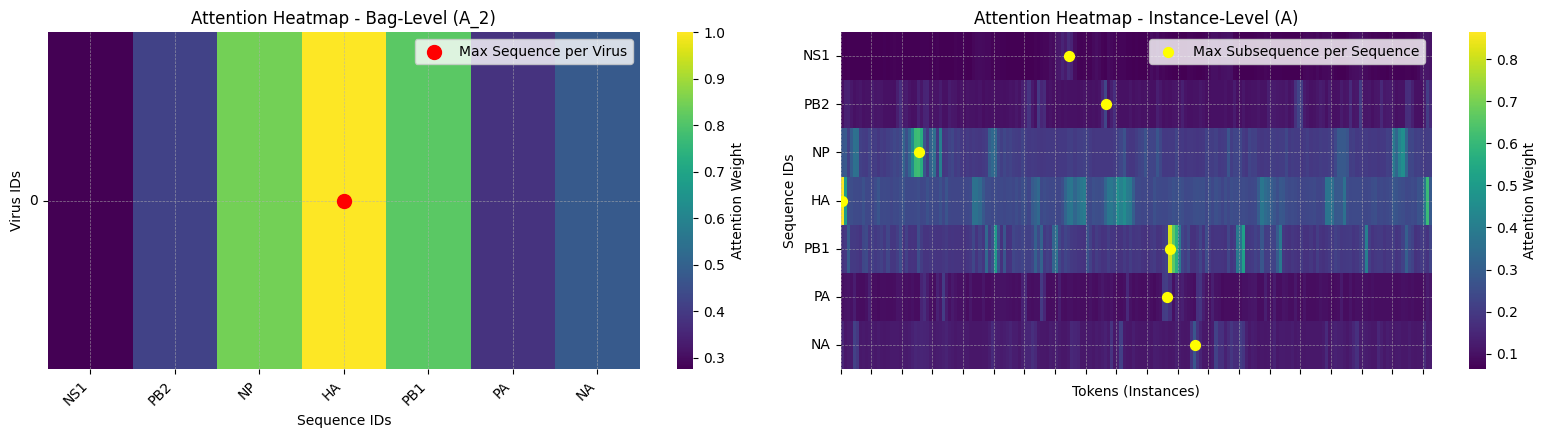

In [18]:
visualize_attention_2d_heatmaps(A, A_2, seq_ids_original, ids_original)